### [用Python投資加密貨幣：爬蟲下載歷史數據 (Part 2)](https://www.finlab.tw/btc-crawler-py/) 

In [5]:
import matplotlib.pyplot as plt

In [2]:
from finlab import crypto
df = crypto.get_all_binance('BTCUSDT', '4h')
df.head()

2022-10-01 04:00:00 2022-10-01 15:36:06.773947


d:\C\Code\crypto_trend\crypto_backtrader\finlab\crypto.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(data)


All caught up..!


,Open,High,Low,Close,Volume,Close_time,Quote_av,Trades,Tb_base_av,Tb_quote_av,Ignore
Timestamp,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865,1.502957e+12,3.531943e+05,334.0,64.013727,275647.421911,8048.127886
2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882,1.502971e+12,2.825012e+05,248.0,58.787633,261054.051154,8020.698096
2017-08-17 12:00:00,4436.06,4485.39,4333.42,4352.34,174.562001,1.502986e+12,7.742388e+05,858.0,125.184133,555419.758061,8133.190658
2017-08-17 16:00:00,4352.33,4354.84,4200.74,4325.23,225.109716,1.503000e+12,9.652911e+05,986.0,165.036363,707808.200922,8425.112852
2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913,1.503014e+12,1.079545e+06,1001.0,203.226685,878286.968557,8733.911395


<AxesSubplot:xlabel='Timestamp'>

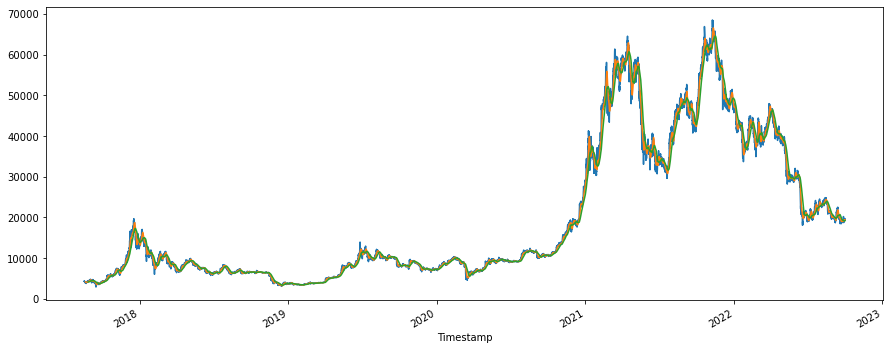

In [12]:
sma1 = df.Close.rolling(20).mean()
sma2 = df.Close.rolling(60).mean()

plt.figure(figsize=(15,6))
df.Close.plot()
sma1.plot()
sma2.plot()

<AxesSubplot:xlabel='Timestamp'>

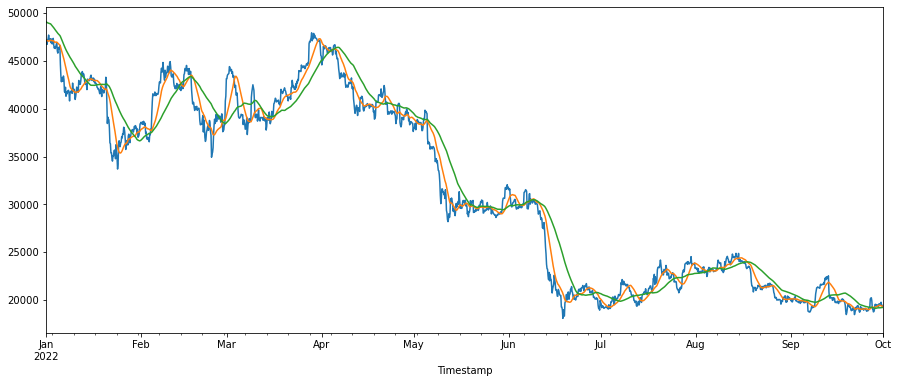

In [11]:
plt.figure(figsize=(15,6))

T_year = "2022"
df.Close[T_year].plot()
sma1[T_year].plot()
sma2[T_year].plot()

In [10]:
condition = sma1 > sma2
condition

Timestamp
2017-08-17 04:00:00    False
2017-08-17 08:00:00    False
2017-08-17 12:00:00    False
2017-08-17 16:00:00    False
2017-08-17 20:00:00    False
                       ...  
2022-09-30 12:00:00     True
2022-09-30 16:00:00     True
2022-09-30 20:00:00     True
2022-10-01 00:00:00     True
2022-10-01 04:00:00     True
Name: Close, Length: 11210, dtype: bool

pd.Series.shift(n)  是一個好用的function，可以將時間序列全部都往後延遲一天

四小時級別中 n=1 => 4小時前；n=2 => 8小時前

In [13]:
print(df.Close)
print(df.Close.shift(1))

Timestamp
2017-08-17 04:00:00     4349.99
2017-08-17 08:00:00     4427.30
2017-08-17 12:00:00     4352.34
2017-08-17 16:00:00     4325.23
2017-08-17 20:00:00     4285.08
                         ...   
2022-09-30 12:00:00    19756.01
2022-09-30 16:00:00    19473.52
2022-09-30 20:00:00    19422.61
2022-10-01 00:00:00    19416.05
2022-10-01 04:00:00    19298.37
Name: Close, Length: 11210, dtype: float64
Timestamp
2017-08-17 04:00:00         NaN
2017-08-17 08:00:00     4349.99
2017-08-17 12:00:00     4427.30
2017-08-17 16:00:00     4352.34
2017-08-17 20:00:00     4325.23
                         ...   
2022-09-30 12:00:00    19436.29
2022-09-30 16:00:00    19756.01
2022-09-30 20:00:00    19473.52
2022-10-01 00:00:00    19422.61
2022-10-01 04:00:00    19416.05
Name: Close, Length: 11210, dtype: float64


做多: 當(今天短週期均線 > 今天長週期均線) 且 (昨天短週期均線 < 昨天長週期均線)  <br>
做空: 當(今天短週期均線 < 今天長週期均線) 且 (昨天短週期均線 > 昨天長週期均線)

In [14]:
signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

這張圖 **-1 顯示：賣出訊號**;**1 是買進訊號** 當我們將 True False 轉換成 int 時，會轉換成「1」跟「0」的數值。

<AxesSubplot:xlabel='Timestamp'>

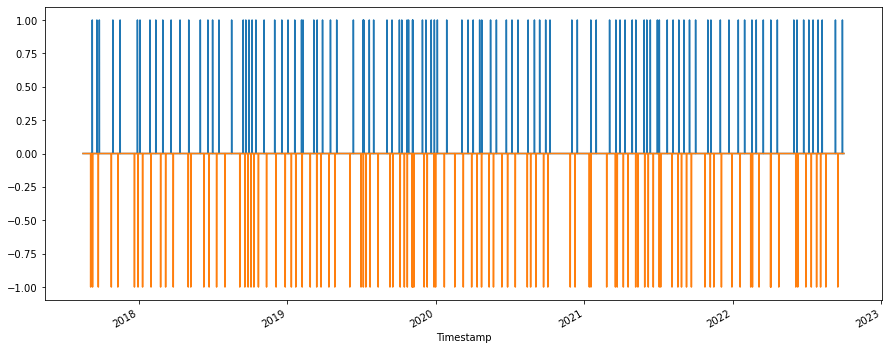

In [16]:
plt.figure(figsize=(15,6))
signal_long.astype(int).plot()
(-signal_short.astype(int)).plot()

In [17]:
# combine long and short signal
signal = signal_long.copy()
signal[signal_short] = -1

In [ ]:
from finlab import crypto
from backtesting import Backtest
from backtesting.lib import SignalStrategy
import pandas as pd



class Strategy(SignalStrategy):
    
    n1 = 20
    n2 = 60
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        sma1 = close.rolling(self.n1).mean()
        sma2 = close.rolling(self.n2).mean()
        
        # Precompute signal
        signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
        signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())
        
        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # add signal
        self.set_signal(signal)



df = crypto.get_all_binance('BTCUSDT', '4h')
bt = Backtest(df, Strategy)
result1 = bt.run()



欄位	說明 <br>
---
Start	起始時間 <br>
End	結束時間<br>
Duration	經過天數<br>
Exposure [%]	投資比率<br>
Equity Final [$]	最終資產<br>
Equity Peak [$]	最高資產<br>
Return [%]	報酬率<br>
Buy & Hold Return [%]	買入持有報酬率<br>
Max. Drawdown [%]	最大交易回落<br>
Avg. Drawdown [%]	平均交易回落<br>
Max. Drawdown Duration	最長交易回落期間<br>
Avg. Drawdown Duration	平均交易回落期間<br>
Win Rate [%]	勝率<br>
Best Trade [%]	最好交易報酬率<br>
Worst Trade [%]	最差交易報酬率<br>
Avg. Trade [%]	平均交易報酬率<br>
Max. Trade Duration	最長交易間隔<br>
Avg. Trade Duration	平均交易間隔<br>
Expectancy [%]	期望值<br>
SQN	系統品質指標<br>
Sharpe Ratio	夏普比率<br>
Sortino Ratio	索丁諾比率<br>
Calmar Ratio	卡瑪比率<br>
_strategy	使用策略名稱<br>

In [27]:
result1

Start                     2017-08-17 04:00:00
End                       2022-10-01 12:00:00
Duration                   1871 days 08:00:00
Exposure Time [%]                   54.191937
Equity Final [$]                     81063.83
Equity Peak [$]                      88269.82
Return [%]                           710.6383
Buy & Hold Return [%]               344.64631
Return (Ann.) [%]                   50.384082
Volatility (Ann.) [%]               53.508447
Sharpe Ratio                          0.94161
Sortino Ratio                        2.457866
Calmar Ratio                         1.177424
Max. Drawdown [%]                  -42.791789
Avg. Drawdown [%]                   -3.867838
Max. Drawdown Duration     1069 days 04:00:00
Avg. Drawdown Duration       20 days 14:00:00
# Trades                                  103
Win Rate [%]                        36.893204
Best Trade [%]                      97.938874
Worst Trade [%]                    -16.312675
Avg. Trade [%]                    

In [24]:
result2 = bt.optimize(n1=range(5, 100, 5),
                      n2=range(5, 100, 5))

c:\Users\benzy\anaconda3\envs\PY_Env\lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 361 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

In [29]:
print(result2.loc['_strategy'])

Strategy(n1=10,n2=80)
